In [1]:
import sys
import os

import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import virga.justdoit as vj
import virga.justplotit as cldplt
jpi.output_notebook()
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
import matplotlib
import pandas as pd
matplotlib.rcParams['animation.embed_limit'] = 2**128
%matplotlib inline
import xarray

Loading BokehJS ...

In [2]:
#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

ck_db = f"../data/kcoeff_2020/sonora_2020_feh{mh}_co_{CtoO}.data.196"

#sonora bobcat cloud free structures file
sonora_profile_db = '../data/sonora_bobcat/structures_m+0.0'
sonora_dat_db = '../data/sonora_bobcat/structures_m+0.0'

In [57]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

teff= 250 # Effective Temperature of your Brown Dwarf in K
grav = 316 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

In [4]:
nlevel = 91 # number of plane-parallel levels in your code
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [5]:
nofczns = 1 # number of convective zones initially
nstr_upper = 60 # top most level of guessed convective zone
nstr_deep = nlevel - 2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

In [41]:
def twod_to_threed(arr, reps=4):
    """
    Takes in a 2D array of size (r, c) and repeats it along the last axis to make an array of size (r, c, reps).
    """
    return np.repeat(arr[:, :, np.newaxis], reps, axis=2)

In [59]:

cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, cloudy = "fixed", mh = '0.0', 
                      CtoO = '1.0',species = ['H2O'], fsed = 8.0, beta = 0.1, virga_param = 'const',
                      mieff_dir = "~/projects/clouds/virga/refrind", do_holes = False, fhole = 0.5, fthin_cld = 0.9, moistgrad = False,
                      opd_climate=twod_to_threed(np.load("../data/patchy_clouds_refcloud/opd.npy")),
                      w0_climate=twod_to_threed(np.load("../data/patchy_clouds_refcloud/w0.npy")),
                      g0_climate=twod_to_threed(np.load("../data/patchy_clouds_refcloud/g0.npy"))
                      )

Cloudy functionality still in beta form and not ready for public use.


In [265]:
cl_run.inputs["climate"]["cloudy"] = "selfconsistent"

In [282]:
cl_run.inputs["climate"]["guess_temp"] = out["temperature"]

In [285]:
cl_run.inputs["climate"]["guess_temp"][np.isnan(out["temperature"])] = out["temperature"][0]

In [286]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

In t_start: Converged Solution in iterations  0
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False
Max TAUCLD diff is 7.529499933839743  Tau tolerance is  1.5058999867679486
Big iteration is  10.1 0
In t_start: Converged Solution in iterations  0
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False
Max TAUCLD diff is 7.439972916557865  Tau tolerance is  4.499794556847471
Big iteration is  10.093965946470703 1
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False
Max TAUCLD diff is 4.673220646338262  Tau tolerance is  6.864092691274241
Big iteration is  130.5685204050317 2
In t_start: Converged Solution in iterations  4
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn

SystemError: CPUDispatcher(<function t_start at 0x14eb1afc0>) returned a result with an exception set

In [175]:
bundle = jdi.inputs(calculation='brown')
bundle.phase_angle(0)
bundle.gravity(gravity=grav, gravity_unit=u.Unit('m/s**2'))
temp, pressure = out["temperature"], out["pressure"]
bundle.add_pt(temperature, pressure)
bundle.premix_atmosphere(opacity_ck, df = bundle.inputs['atmosphere']['profile'].loc[:,['pressure','temperature']])
DTAU, TAU, W0, COSB,ftau_cld, ftau_ray,GCOS2, DTAU_OG, TAU_OG, W0_OG, COSB_OG, \
                    W0_no_raman, surf_reflect, ubar0,ubar1,cos_theta, single_phase,multi_phase, \
                    frac_a,frac_b,frac_c,constant_back,constant_forward, \
                    wno,nwno,ng,nt, nlevel, ngauss, gauss_wts, mmw, gweight,tweight = jdi.calculate_atm(bundle, opacity_ck)
bb, y2, tp = 0, 0, 0
FOPI = np.zeros(opacity_ck.nwno) + 1.0
Teff = cl_run.inputs["planet"]["T_eff"]
min_temp = min(opacity_ck.temps)
max_temp = max(opacity_ck.temps)
if Teff > 300:
    tmin = min_temp*(1-extension)
else:
    tmin = 10
tmax = max_temp*(1.3)
# tmax = 10000
dt = bundle.inputs['climate']['dt_bb_grid']
ntmps = int((tmax-tmin)/dt)
flux_net_v_layer_full, flux_net_v_full, flux_plus_v_full, flux_minus_v_full , flux_net_ir_layer_full, flux_net_ir_full, flux_plus_ir_full, flux_minus_ir_full = jdi.get_fluxes(pressure, temp, opacity_ck.delta_wno, bb , y2, tp, tmin, tmax, DTAU, TAU, W0, 
                    COSB,ftau_cld, ftau_ray,GCOS2, DTAU_OG, TAU_OG, W0_OG, COSB_OG, W0_no_raman, surf_reflect, 
                    ubar0,ubar1,cos_theta, FOPI, single_phase,multi_phase,frac_a,frac_b,frac_c,constant_back,constant_forward, 
                    wno,nwno,ng,nt,gweight,tweight, nlevel, ngauss, gauss_wts,True, True)#True for reflected, True for thermal
mean_molecular_weight = np.mean(mmw)
sigma_sb = 0.56687e-4
tidal = np.zeros_like(pressure) - sigma_sb *(Teff**4)
grad = bundle.inputs["climate"]["grad"]
cp = bundle.inputs['climate']['cp']
nstr = out["cvz_locs"]

In [224]:
kzz = jdi.get_kzz(
    out["pressure"], out["temperature"],grav,mmw,tidal,flux_net_ir_layer_full, flux_net_ir_layer_full,
    cl_run.inputs["climate"]["t_table"], cl_run.inputs["climate"]["p_table"], cl_run.inputs["climate"]["grad"], cl_run.inputs["climate"]["cp"],
    0,list(nstr),bundle.inputs['atmosphere']['profile'].T.values
)
bundle.inputs['atmosphere']['profile']['temperature'] = temp
bundle.inputs['atmosphere']['profile']['kz'] = kzz

In [263]:
cld_out = bundle.virga(["H2O"],"~/projects/clouds/virga/refrind", fsed=8.0,mh=1.0,mmw = mean_molecular_weight, b = 0.1, param = 'const')

Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False


In [264]:
np.all(cld_out["opd_per_layer"] == 0)

True

In [243]:
cld_out_df = vj.picaso_format(cld_out["opd_per_layer"], cld_out["single_scattering"], cld_out["asymmetry"], cld_out["pressure"], 1e4 / cld_out["wave"])

In [252]:
opa_mon = jdi.opannection()

hi_res = jdi.inputs(calculation="browndwarf") # start a calculation
grav = 316 # Gravity of your brown dwarf in m/s/s
hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

hi_res.atmosphere(df=out['ptchem_df'])
hi_res.clouds(df=cld_out_df)

df_spec1 = hi_res.spectrum(opa_mon, calculation='thermal', full_output= True)

wno, fp = df_spec1['wavenumber'], df_spec1['thermal'] #erg/cm2/s/cm
xmicron = 1e4/wno

flamy = fp*1e-8  # per anstrom instead of per cm
sp = jdi.psyn.ArraySpectrum(xmicron, flamy,
                           waveunits='um',
                           fluxunits='FLAM')
sp.convert("um")
sp.convert('Fnu')  # erg/cm2/s/Hz

wno = sp.wave  # micron
fp = sp.flux  # erg/cm2/s/Hz
df_spec1['fluxnu'] = fp
wno,fp = jdi.mean_regrid(1e4/wno,fp, R=200)


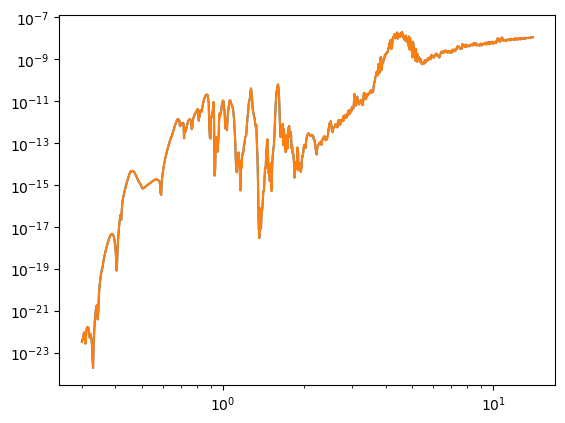

In [250]:
plt.loglog(1e4/wno,fp_cloudless)
plt.loglog(1e4/wno,fp)
plt.show()